# Import

In [1]:
import numpy as np
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib as mpl
from stable_baselines3 import TD3

import sys
import os
local_path = '/Users/riccardo/Documents/GitHub/' #'path_to_progect_folder/'
sys.path.append(local_path+'OptimalControlAttacks/SyntheticDataExperiments/')
from Modules import GreedyAttacks as GA
from Modules import ConstantAttacks as CoA
from Modules import ClairvoyantAttacks as ClA
from Modules import DeepRLAttacks as RLA
from Modules import AuxiliaryFunctions as AF
from Parameters import ParametersAttacksComparison_2LayerNN as Par

# Colors

In [2]:
green = '#7FB285'
coral = '#FF8360'
light_blue = '#3C8DAD'
lavander = '#D5C6E0'
light_red = '#FF616D'
orange = '#F5A962'

# Parameters

In [3]:
# Model
model_name = Par.model_name
activation = Par.activation
output_scaling = Par.output_scaling
hiddenlayer_width = Par.hiddenlayer_width
target_type = Par.target_type
train_first_layer = Par.train_first_layer

# Input data parameters
dim_input = Par.dim_input
batch_size = Par.batch_size
mu_x = Par.mu_x
sigma_x = Par.sigma_x
n_runs_experiments = Par.n_runs_experiments

# Dynamics parameters
learning_rate = Par.learning_rate
gamma = Par.gamma
beta = Par.beta

# N. samples
n_timesteps = Par.n_timesteps
n_timesteps_transient_th = Par.n_timesteps_transient_th
n_timesteps_past = Par.n_timesteps_past
n_samples_average = Par.n_samples_average
n_samples_buffer = Par.n_samples_buffer
n_samples_test = Par.n_samples_test
time_window = Par.time_window

# Control parameters
a_min = Par.a_min
a_max = Par.a_max
n_a_gridpoints = Par.n_a_gridpoints
n_runs_calibration = Par.n_runs_calibration
control_cost_weight = Par.control_cost_weight
greedy_weight_future = Par.greedy_weight_future
opt_pref = Par.opt_pref
fut_pref = Par.fut_pref

# DeepRL Agent
agent_model_name = Par.agent_model_name
n_actions = Par.n_actions
use_action_noise = Par.use_action_noise
action_noise_mean = Par.action_noise_mean
action_noise_std = Par.action_noise_std
observation_type = Par.observation_type 
use_small_achitecture = Par.use_small_achitecture
shuffle_array = Par.shuffle_array
learning_rate_agent = Par.learning_rate_agent
activation_fn = Par.activation_fn
n_episodes = Par.n_episodes
save_freq = Par.save_freq
train_freq = Par.train_freq

# Strings/paths
experiment_description = Par.experiment_description
path_agent = Par.path_agent
export_path = Par.export_path
rlmodels_path = Par.rlmodels_path

# Arrays

In [4]:
# Arrays (assuming batch_size as specified above)
x_incoming_arr = np.random.normal(mu_x, sigma_x, (n_runs_experiments, batch_size*n_timesteps, dim_input))
x_past = np.random.normal(mu_x, sigma_x, (batch_size*n_timesteps_past, dim_input))
x_buffer = np.random.normal(mu_x, sigma_x, (batch_size*n_samples_buffer, dim_input))
x_test = np.random.normal(mu_x, sigma_x, (batch_size*n_samples_test, dim_input))

# Single run

In [5]:
run_index = 0
x_incoming = x_incoming_arr[run_index]

In [6]:
# Seed
np.random.seed(seed=0)

# Teacher
W_teach = np.random.normal(0, 1, (hiddenlayer_width, dim_input))
W_teach = W_teach / (np.sum(W_teach**2, axis=1).reshape(-1,1).repeat(dim_input, axis=1)/dim_input)**0.5
v_teach = np.random.normal(0, 1, hiddenlayer_width)
v_teach = v_teach / ((np.sum(v_teach**2)/hiddenlayer_width))**0.5
# Target
if target_type=='FlippedTeacher':
    W_target = W_teach.copy()
    v_target = -v_teach.copy()
elif target_type=='Random':
    W_target = np.random.normal(0, 1, (hiddenlayer_width, dim_input))
    W_target = W_target / (np.sum(W_target**2, axis=1).reshape(-1,1).repeat(dim_input, axis=1)/dim_input)**0.5
    v_target = np.random.normal(0, 1, hiddenlayer_width)
    v_target = v_target / ((np.sum(v_target**2)/hiddenlayer_width))**0.5
# Student (initial condition)
W_stud_0 = W_teach.copy()
v_stud_0 = v_teach.copy()

# Action cost pre-factor
label_t_test = GA.NN2L(x_test, W_teach, v_teach, activation=activation, output_scaling=output_scaling)
label_o_test = GA.NN2L(x_test, W_target, v_target, activation=activation, output_scaling=output_scaling)
error_target_teach = np.mean((label_o_test-label_t_test)**2)
d_target_teach = 0.5 * error_target_teach
pref_control_cost_weight = (2*d_target_teach)
print('Pre-factor control cost: %.2f' % pref_control_cost_weight)

Pre-factor control cost: 3.22


## Constant

In [10]:
opt_a_const = False
a_const = 0.5
results_constant = CoA.exp_const_NN2L(x_incoming=x_incoming, 
                                      x_past=x_past, 
                                      x_buffer=x_buffer, 
                                      x_test=x_test,
                                      eta=learning_rate,
                                      W_teach=W_teach, 
                                      v_teach=v_teach, 
                                      W_target=W_target,
                                      v_target=v_target,
                                      W_stud_0=W_stud_0,
                                      v_stud_0=v_stud_0,
                                      dim_input=dim_input,
                                      a_const=a_const,
                                      a_min=a_min, 
                                      a_max=a_max,
                                      beta=beta, 
                                      control_cost_weight=control_cost_weight,
                                      batch_size=batch_size,
                                      n_gridpoints=n_a_gridpoints,
                                      buffer_size=n_samples_average,
                                      transient_th=n_timesteps_transient_th,
                                      window_steadystate=time_window,
                                      activation=activation,
                                      n_av=n_runs_calibration, 
                                      output_scaling=output_scaling,
                                      train_first_layer=train_first_layer)

Control cost weight: 3.2152231187421516
Training...
1/5000
500/5000
1000/5000
1500/5000
2000/5000
2500/5000
3000/5000
3500/5000
4000/5000
4500/5000
5000/5000


In [11]:
a_dynamics_const = results_constant['a_dynamics']
nef_cost_dynamics_const = results_constant['nef_cost_dynamics']
per_cost_dynamics_const = results_constant['per_cost_dynamics']
cum_cost_dynamics_const = results_constant['cum_cost_dynamics']

## Greedy

In [12]:
print(fut_pref)
print(opt_pref)
fut_pref_interval = 0.1
fut_pref_min = 0.5
fut_pref_max = 1.5 + fut_pref_interval

opt_pref_local = False
fut_pref_local = 1.6

results_greedy = GA.exp_greedy_NN2L(x_incoming=x_incoming, 
                                    x_past=x_past, 
                                    x_buffer=x_buffer, 
                                    x_test=x_test,
                                    eta=learning_rate,
                                    W_teach=W_teach, 
                                    v_teach=v_teach, 
                                    W_target=W_target,
                                    v_target=v_target,
                                    W_stud_0=W_stud_0,
                                    v_stud_0=v_stud_0,
                                    dim_input=dim_input,
                                    weight_future=greedy_weight_future,
                                    a_min=a_min, 
                                    a_max=a_max,
                                    beta=beta, 
                                    control_cost_weight=control_cost_weight,
                                    batch_size=batch_size,
                                    n_gridpoints=n_a_gridpoints,
                                    buffer_size=n_samples_average,
                                    transient_th=n_timesteps_transient_th,
                                    window_steadystate=time_window,
                                    activation=activation,
                                    opt_pref=opt_pref_local, 
                                    fut_pref=fut_pref_local,
                                    fut_pref_interval=fut_pref_interval,
                                    fut_pref_min=fut_pref_min, 
                                    fut_pref_max=fut_pref_max,
                                    n_av=n_runs_calibration, 
                                    output_scaling=output_scaling,
                                    train_first_layer=train_first_layer)

2
True
Control cost weight: 3.2152231187421516
Training...
1/5000
500/5000
1000/5000
1500/5000
2000/5000
2500/5000
3000/5000
3500/5000
4000/5000
4500/5000
5000/5000


In [13]:
a_dynamics_greedy = results_greedy['a_dynamics']
nef_cost_dynamics_greedy = results_greedy['nef_cost_dynamics']
per_cost_dynamics_greedy = results_greedy['per_cost_dynamics']
cum_cost_dynamics_greedy = results_greedy['cum_cost_dynamics']
d_dynamics_greedy = results_greedy['d_dynamics']

## Clairvoyant

In [14]:
# No evaluation

## DeepRL

In [7]:
# Load performance
models_description = '_agent#%s' % (agent_model_name)
name = 'ObjectiveVSTrainingSteps'
filename = name + '_@@@' + models_description + experiment_description + '.npy'
obj_vs_trainingsteps = np.load(rlmodels_path + filename, allow_pickle=True)
name = 'TrainingSteps'
filename = name + '_@@@' + models_description + experiment_description + '.npy'
trainingsteps = np.load(rlmodels_path + filename, allow_pickle=True)

# Poisoning environment
randomise_initial_condition = False
shuffle_array = False
env = RLA.EnvironmentNN2L(observation_type=observation_type,
                          x_arr=x_incoming,
                          batch_size=batch_size,
                          W_stud_0=W_stud_0, 
                          v_stud_0=v_stud_0,
                          W_teach=W_teach, 
                          v_teach=v_teach, 
                          W_target=W_target, 
                          v_target=v_target, 
                          a_min=a_min,
                          a_max=a_max,
                          learning_rate=learning_rate, 
                          control_cost_weight=pref_control_cost_weight*control_cost_weight, 
                          activation=activation,
                          shuffle_array=shuffle_array, 
                          outputscaling=output_scaling, 
                          train_first_layer=train_first_layer)

# Load model
best_model_t = trainingsteps[np.argmin(obj_vs_trainingsteps)]
path_to_model = path_agent + f'/rl_model_{best_model_t}_steps.zip'
#path_to_buffer = path_repbuffer + f'rl_model_replay_buffer_{timesteps_past}_steps.pkl'
if os.path.exists(path_to_model):
    model = TD3.load(path_to_model, env)
    #model_iter.load_replay_buffer(path_to_buffer)
    print('Model: %d steps (episode %d)' % (best_model_t, 1+int(best_model_t/n_timesteps_past))) 
    steps_flag = True
else:
    print('  %d-model not found (ep %d)' % (best_model_t, 1+int(best_model_t/n_timesteps_past))) 
    
# Experiment
results_deeprl = RLA.exp_rl_NN2L(model, env, x_test)
print('Done!')

Model: 72000 steps (episode 8)
Done!


In [9]:
a_dynamics_deeprl = results_deeprl['a_dynamics']
nef_cost_dynamics_deeprl = results_deeprl['nef_cost_dynamics']
per_cost_dynamics_deeprl = results_deeprl['per_cost_dynamics']
cum_cost_dynamics_deeprl = results_deeprl['cum_cost_dynamics']
d_dynamics_deeprl = results_deeprl['d_dynamics']

## Figures

### Steady-state cost comparison

In [15]:
t_end = 4000
#
g_nef_C = nef_cost_dynamics_const[-t_end:]
g_per_C = per_cost_dynamics_const[-t_end:]
g_C = g_per_C + g_nef_C
g_C_mean = np.mean(g_C)
g_C_ci = sms.DescrStatsW(g_C).tconfint_mean(alpha=0.05)
g_C_err = 0.5*(g_C_ci[1]-g_C_ci[0])
#
g_nef_RL = nef_cost_dynamics_deeprl[-t_end:]
g_per_RL = per_cost_dynamics_deeprl[-t_end:]
g_RL = g_per_RL + g_nef_RL
g_RL_mean = np.mean(g_RL)
g_RL_ci = sms.DescrStatsW(g_RL).tconfint_mean(alpha=0.05)
g_RL_err = 0.5*(g_RL_ci[1]-g_RL_ci[0])
#
g_nef_G = nef_cost_dynamics_greedy[-t_end:]
g_per_G = per_cost_dynamics_greedy[-t_end:]
g_G = g_per_G + g_nef_G
g_G_mean = np.mean(g_G)
g_G_ci = sms.DescrStatsW(g_G).tconfint_mean(alpha=0.05)
g_G_err = 0.5*(g_G_ci[1]-g_G_ci[0])


g_mean = np.array([g_C_mean, g_RL_mean, g_G_mean])
g_err = np.array([g_C_err, g_RL_err, g_G_err])

rescale = True
if rescale:
    scale = 1/max(g_mean)
    g_mean = scale * g_mean
    g_err = scale * g_err
g_mean

array([1.        , 0.64663907, 0.62230665])

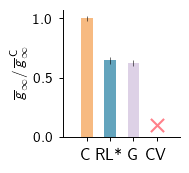

In [16]:
AF.SetPlotParams(magnification=0.7, ratio=float(2.2/2.4), fontsize=11, lines_w=0.7, ms=4)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')


fig, ax = plt.subplots()

dict_errorbars = dict(color='black', alpha=0.8, lw=0.5, capsize=0)

colors = [orange, light_blue, lavander]
y = g_mean
max_y = max(y)
y_err = g_err
x_positions_bars = [1, 2, 3]
x_positions_labels = [1, 2, 3, 4] 
x_labels = ['C', 'RL*', 'G', 'CV']

width = 0.5
lines_w = 0.5
ax.bar(x_positions_bars, y, yerr=y_err, color=colors, alpha=0.8, width=width, lw=lines_w, error_kw=dict_errorbars)

colors = [light_red]
x_positions_crosses = [4]
for i, el in enumerate(x_positions_crosses):
    ax.scatter(el, 0.1*max_y, color=colors[i], marker='x', s=90, alpha=0.8, lw=1.5)

ax.set_xticks(x_positions_labels)
ax.set_xticklabels(x_labels, rotation=0)
ax.set_xlim([min(x_positions_labels)-1, max(x_positions_labels)+1])
if rescale:
    ax.set_ylabel('$\overline{g}_{\infty}/\,\overline{g}^{\mathrm{\,C}}_{\infty}$')
else:
    ax.set_ylabel('$\overline{g}_{\infty}$')
plt.xticks(fontsize=12)
plt.grid()
plt.show()

### Greedy and RL actions

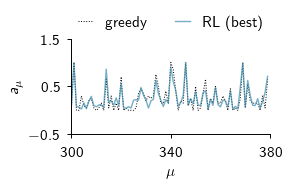

In [18]:
AF.SetPlotParams(magnification=1.05, ratio=float(2.2/3.3), fontsize=11, lines_w=0.7, ms=4)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')


fig, ax = plt.subplots(1, 1)

lw = .7
t_start = 300
t_end = t_start + 80
x = np.arange(t_start, t_end) 
y_G = a_dynamics_greedy[t_start:t_end]
y_RL = a_dynamics_deeprl[t_start:t_end]
color = 'black'
ax.plot(x, y_G, ls=':', marker='', lw=lw, color=color, label='greedy')
color = light_blue
ax.plot(x, y_RL, lw=1., ls='-', marker='', color=color, alpha=0.7, label='RL (best)')

ax.set_xlabel('$\mu$')
ax.set_ylabel('$a_{\mu}$')

plt.grid()
ax.set_xlim([t_start, t_end])
ax.set_xticks([t_start, (t_start+t_end)/2, t_end])
ax.set_yticks([-0.5, 0.5, 1.5])
plt.legend(bbox_to_anchor=(-0., 1.02, 1, 0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)
plt.show()